In [39]:
import os
from ms2deepscore.MS2DeepScore import MS2DeepScore
from ms2deepscore.models.load_model import load_model
from matchms.importing.load_from_mgf import load_from_mgf
from ms2deepscore.utils import load_pickled_file
from ms2deepscore.models.load_model import load_model, load_embedding_evaluator


data_folder = os.path.join("../../../data/pytorch/gnps_21_08_23_min_5_at_5_percent/")
both_mode_folder = "trained_models/both_mode_precursor_mz_ionmode_2000_2000_2000_layers_500_embedding_2024_01_31_11_51_10/"

# Validation spectra
pos_val_spectra = list(load_from_mgf(os.path.join(data_folder, "training_and_validation_split", "positive_validation_spectra.mgf")))
neg_val_spectra = list(load_from_mgf(os.path.join(data_folder, "training_and_validation_split", "negative_validation_spectra.mgf")))
all_val_spectra = pos_val_spectra+neg_val_spectra

ms2ds_model = load_model(os.path.join(data_folder, both_mode_folder, "ms2deepscore_model.pt"))
ms2ds_embedding_evaluator = load_embedding_evaluator(os.path.join(data_folder, both_mode_folder, "embedding_evaluator.pt"))

# Get scores for validation spectra

In [234]:
import numpy as np
from ms2deepscore.models.SiameseSpectralModel import compute_embedding_array
from ms2deepscore.vector_operations import cosine_similarity_matrix
from ms2deepscore.benchmarking.calculate_scores_for_validation import get_tanimoto_score_between_spectra

def select_one_spectrum_per_inchikey(spectra):
    inchikeys14_array = np.array([s.get("inchikey")[:14] for s in spectra])
    unique_inchikeys = np.unique(inchikeys14_array)
    rng = np.random.default_rng(seed=0)
    selected_spectra = []
    for inchikey in unique_inchikeys:
        matching_spectra_idx = np.where(inchikeys14_array == inchikey)[0]
        specrum_id = rng.choice(matching_spectra_idx)
        selected_spectra.append(spectra[specrum_id])
    return selected_spectra

def calculate_MSE(selected_spectra, ms2deepscore_model, embedding_evaluator, nr_of_samples=2000):    
    embeddings = compute_embedding_array(ms2deepscore_model, selected_spectra)
    ms2ds_scores = cosine_similarity_matrix(embeddings, embeddings)
    tanimoto_scores = get_tanimoto_score_between_spectra(selected_spectra, selected_spectra,
                                                         fingerprint_type="daylight",
                                                         nbits=2048,
                                                        )
    predicted_mse = embedding_evaluator.compute_embedding_evaluations(embeddings)
    MSEs = (tanimoto_scores - ms2ds_scores) ** 2
    MAEs = abs(tanimoto_scores - ms2ds_scores)
    return predicted_mse.ravel(), ms2ds_scores, tanimoto_scores, MSEs, MAEs


In [258]:
selected_all_val_spectra = select_one_spectrum_per_inchikey(selected_all_val_spectra)
predicted_mse, ms2ds_scores, tanimoto_scores, val_MSEs, val_MAEs = calculate_MSE(selected_all_val_spectra, ms2ds_model, ms2ds_embedding_evaluator)
ms2ds_scores.shape

1404it [00:08, 174.40it/s]
Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1404/1404 [00:04<00:00, 343.45it/s]


Calculating tanimoto scores


(1404, 1404)

# Benchmark after removing the spectra with highest predicted MSE
This shows that prediction quality indeed improves

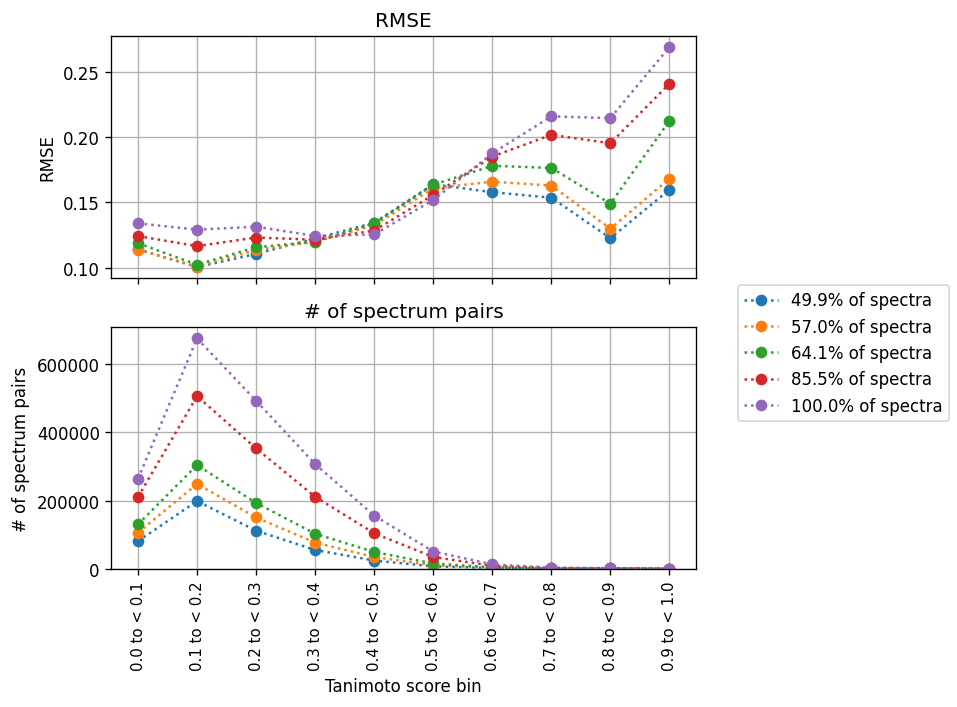

In [260]:
from ms2deepscore.utils import remove_diagonal
from ms2deepscore.benchmarking.plot_rmse_per_bin import plot_rmse_per_bin_multiple_benchmarks

selected_ms2ds_scores = []
selected_tanimoto_scores = []
labels = []
for i in (700, 800, 900, 1200,1404):
    selected_indices = predicted_mse.argsort()[:i]
    selected_ms2ds_scores.append(remove_diagonal(ms2ds_scores[selected_indices][:, selected_indices]))
    selected_tanimoto_scores.append(remove_diagonal(tanimoto_scores[selected_indices][:, selected_indices]))
    labels.append(f"{i/len(predicted_mse)*100:.1f}% of spectra")
plot_rmse_per_bin_multiple_benchmarks(selected_ms2ds_scores, selected_tanimoto_scores, labels)

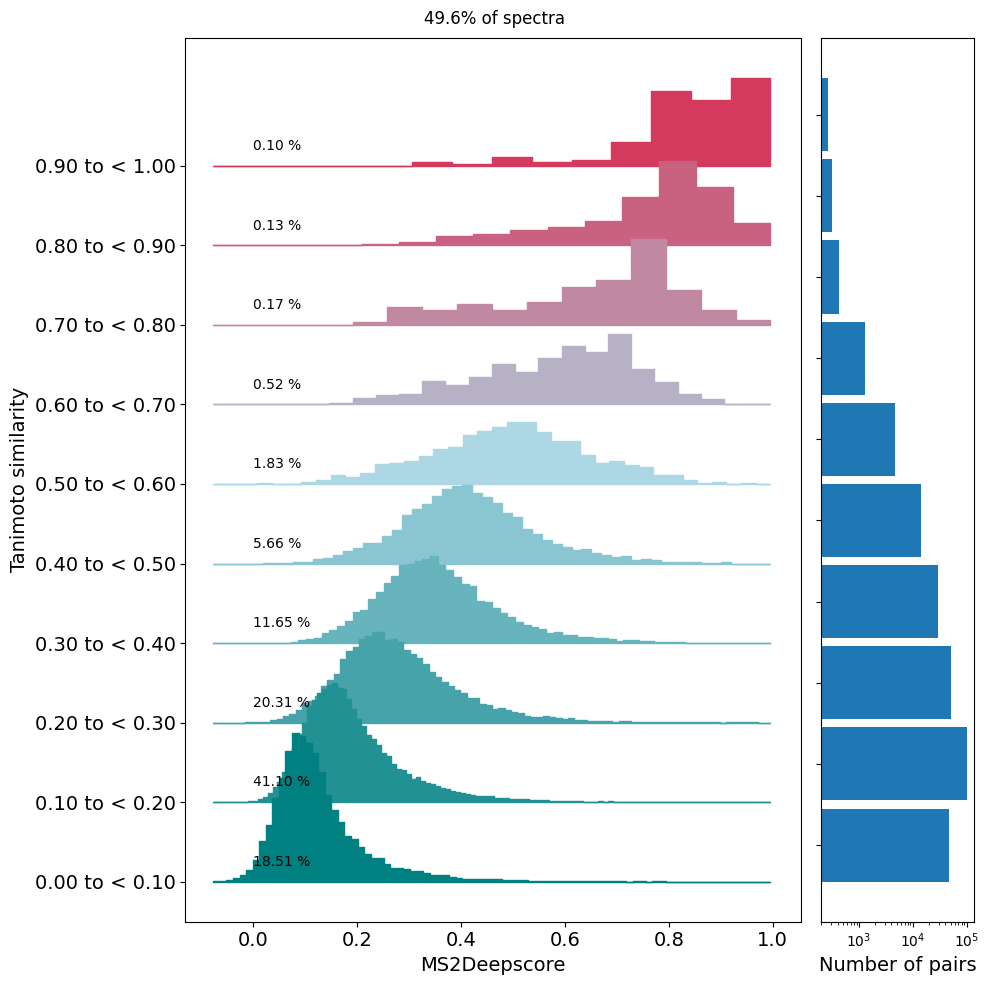

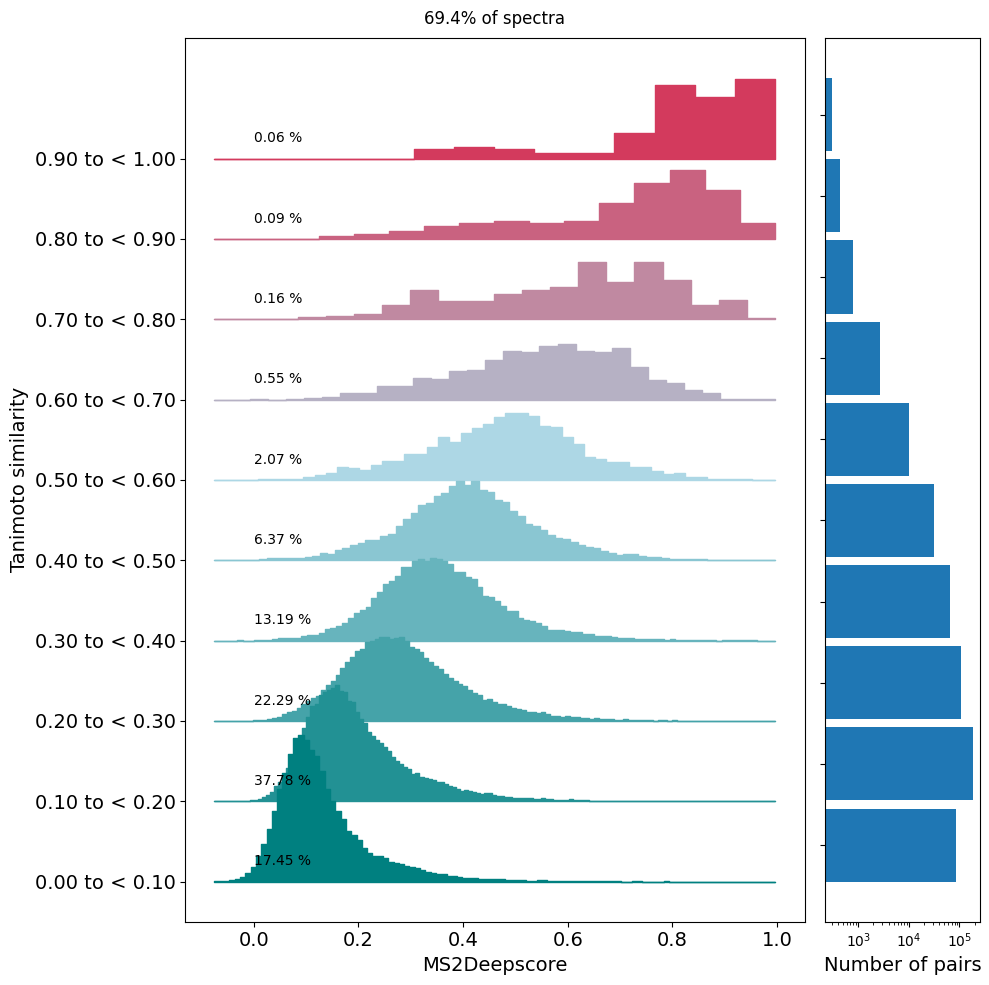

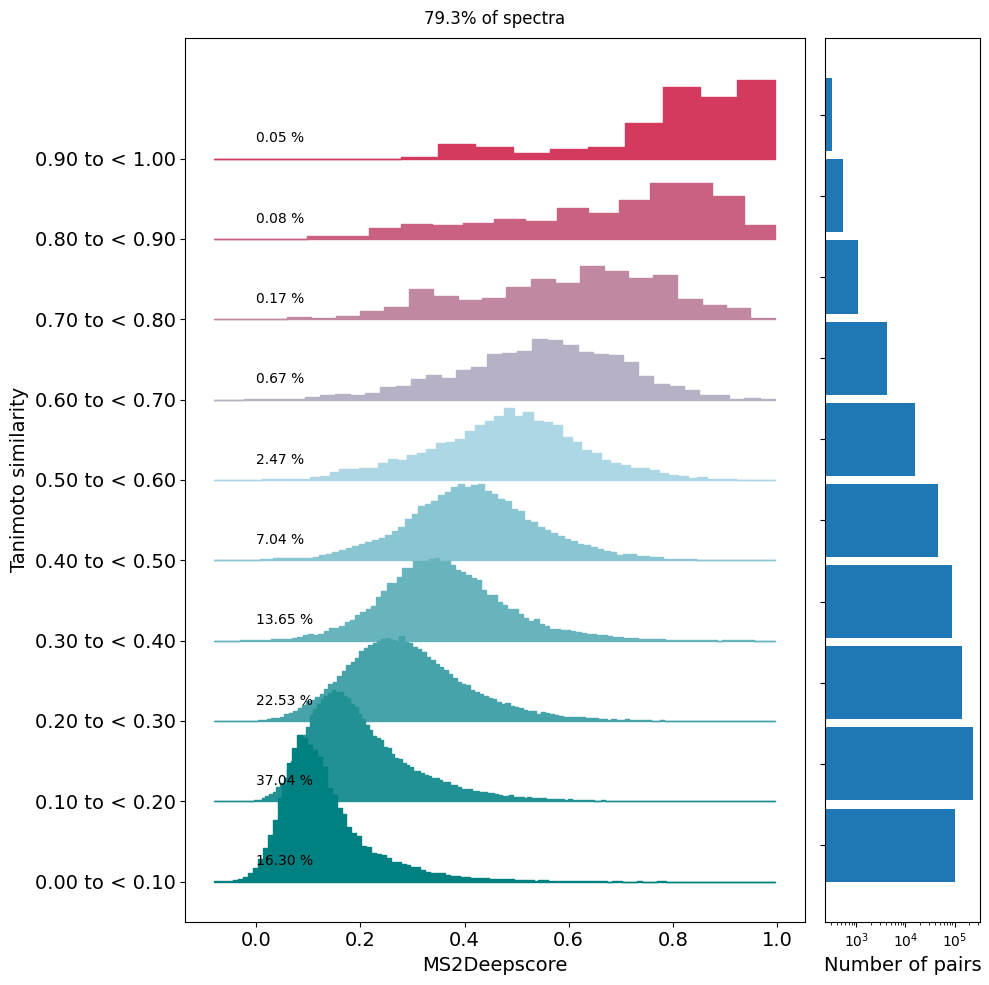

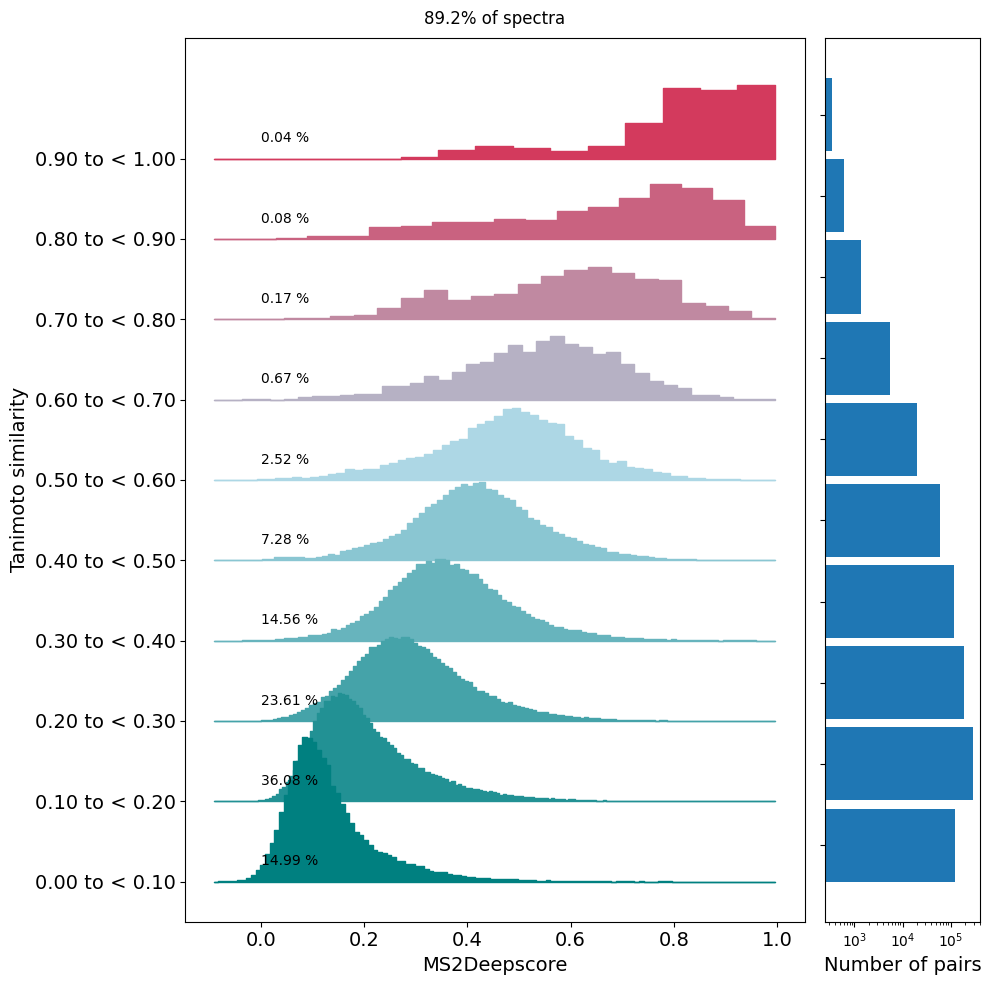

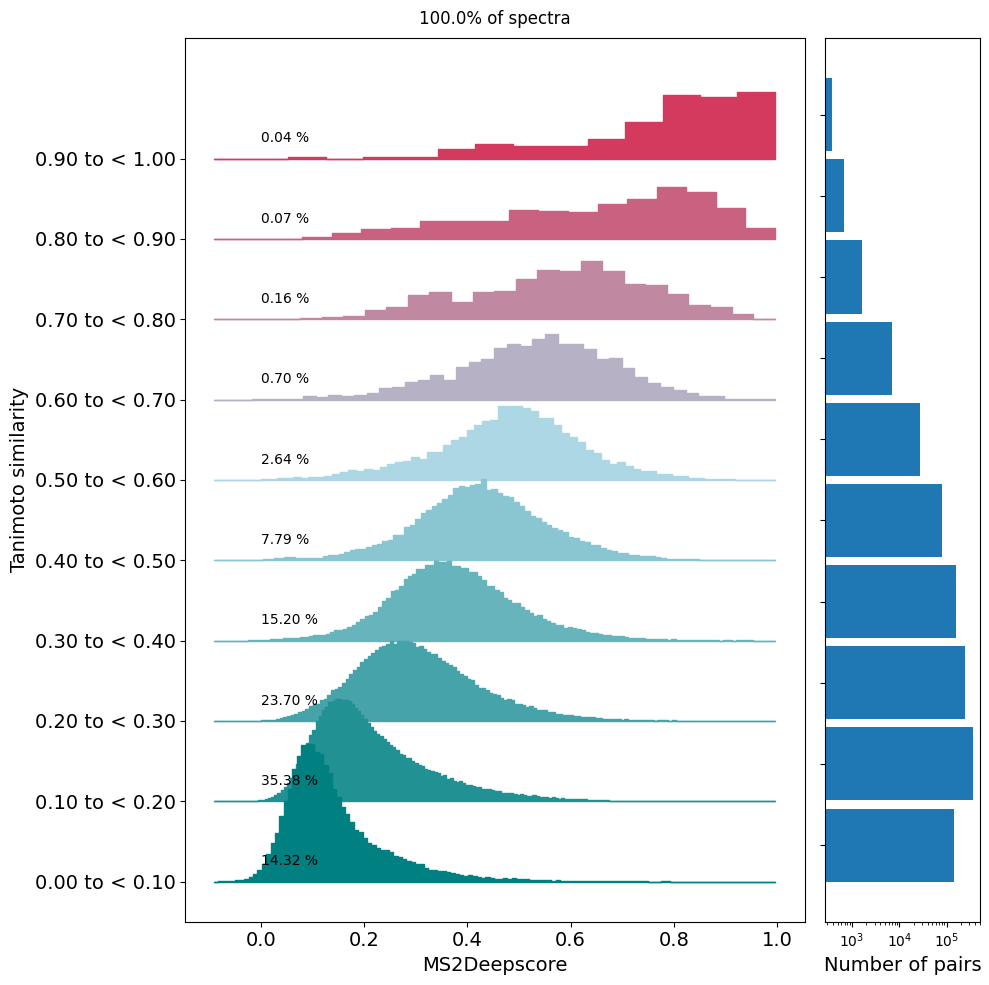

In [114]:
from ms2deepscore.benchmarking.plot_stacked_histogram import plot_stacked_histogram_plot_wrapper
for i in range(len(selected_tanimoto_scores)):
    plot_stacked_histogram_plot_wrapper(selected_tanimoto_scores[i], selected_ms2ds_scores[i], 10, labels[i])

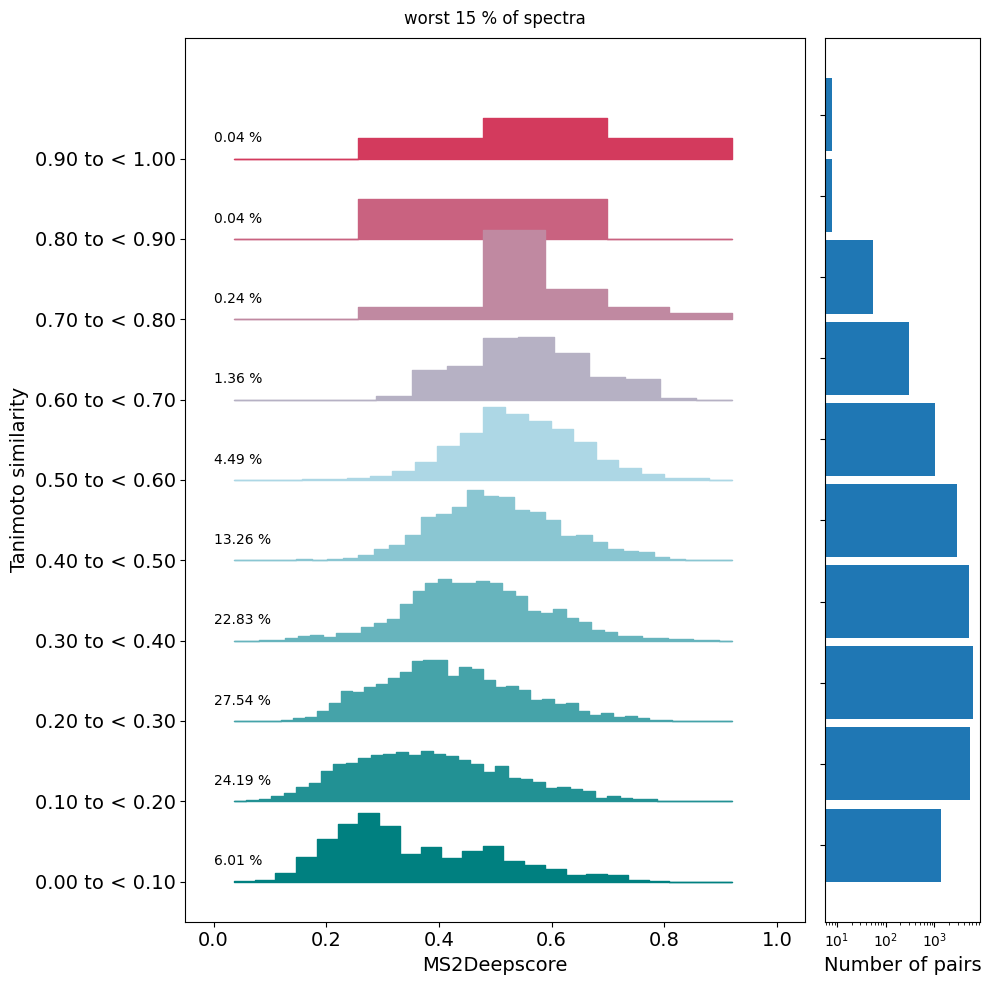

In [250]:
selected_indices = predicted_mse.argsort()[-150:]
plot_stacked_histogram_plot_wrapper(remove_diagonal(tanimoto_scores[selected_indices][:, selected_indices]), 
                                    remove_diagonal(ms2ds_scores[selected_indices][:, selected_indices]), 10, "worst 15 % of spectra"
                                   )

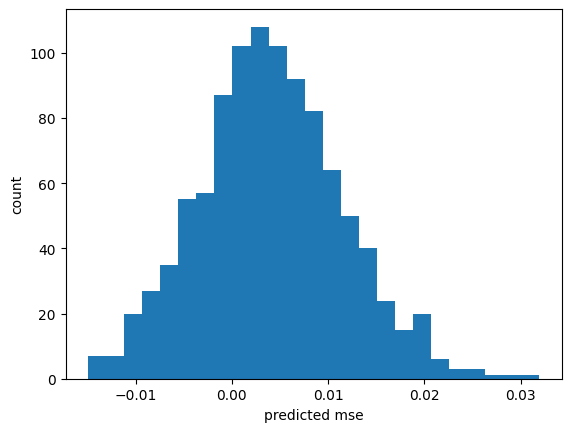

In [118]:
plt.hist(predicted_val_mse, 25)
plt.xlabel("predicted mse")
plt.ylabel("count")
plt.show()

Text(0.5, 0, 'Actual MSE')

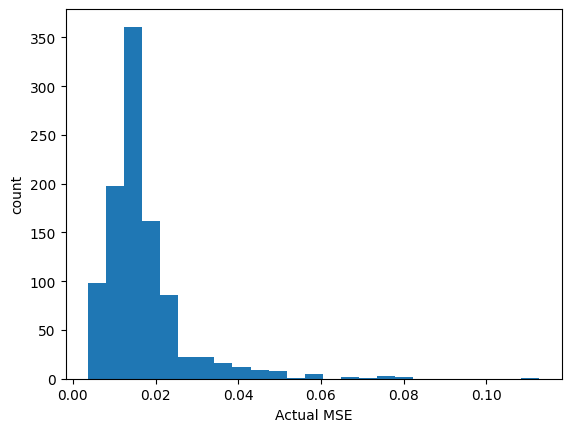

In [120]:
plt.hist(val_MSEs.mean(axis=1), 25)
plt.ylabel("count")
plt.xlabel("Actual MSE")
# plt.xlim(0, 0.16)

Text(0, 0.5, 'True MSE')

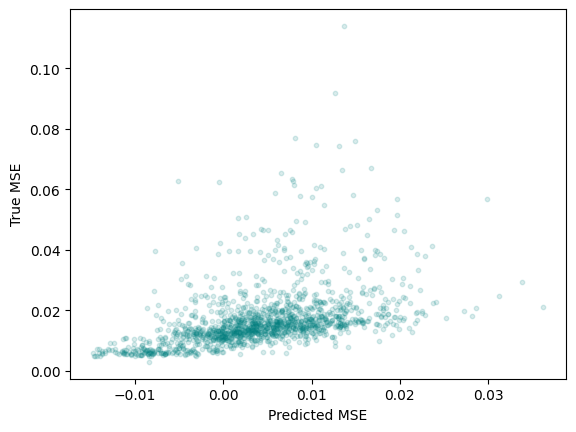

In [261]:
from matplotlib import pyplot as plt

plt.scatter(predicted_mse, val_MSEs.mean(axis=1), alpha=0.15, s=10, color="teal")
plt.xlabel("Predicted MSE")
plt.ylabel("True MSE")

Text(0, 0.5, 'predicted mse')

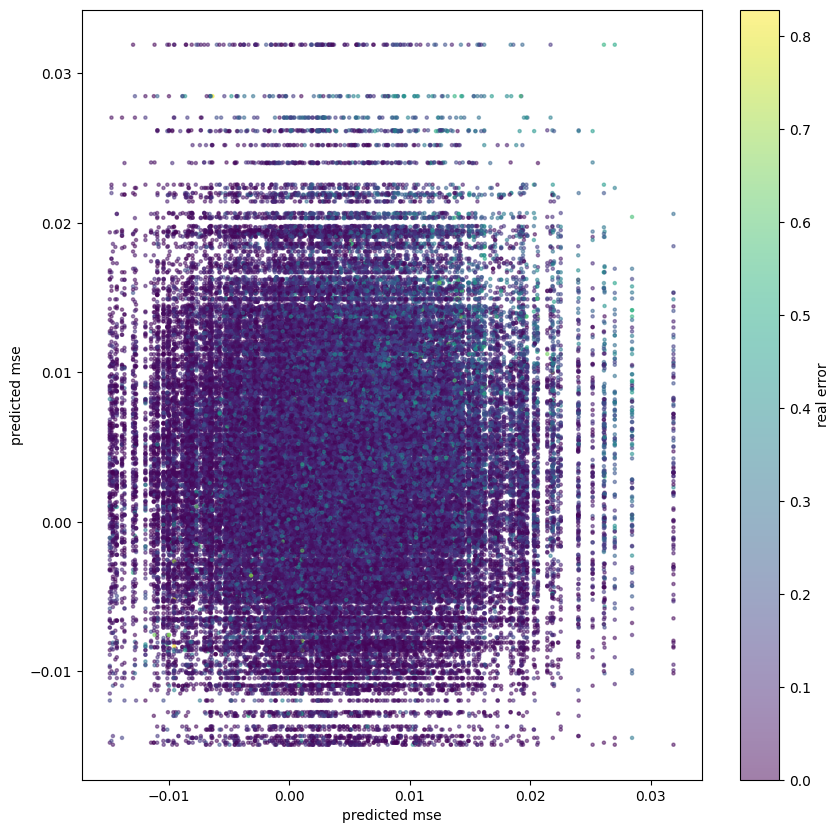

In [188]:
indexes = np.arange(predicted_mse.shape[0])
assert predicted_mse.shape[0] == val_MSEs.shape[0] == val_MSEs.shape[1]
rng = np.random.default_rng(seed=0)
sample_idx_1 = rng.choice(indexes, 100000)
sample_idx_2 = rng.choice(indexes, 100000)
plt.figure(figsize=(10, 10))

plt.scatter(predicted_mse[sample_idx_1], predicted_mse[sample_idx_2],
            c=val_MSEs[sample_idx_1,sample_idx_2]**0.5, s=5, alpha=0.5, cmap="viridis"
           )
cb = plt.colorbar()
cb.set_label("real error")
plt.xlabel("predicted mse")
plt.ylabel("predicted mse")

# Using the datagenerator as input
By using the datagenerator we don't sample 1 spectrum per inchikey, instead we sample all spectra equally. So it would be similar to using the entire set of all_val_spectra set. (which we don't since the matrixes would become annoyingly big too handle) 

In [146]:
from ms2deepscore.train_new_model.data_generators import DataGeneratorEmbeddingEvaluation
from ms2deepscore.SettingsMS2Deepscore import SettingsEmbeddingEvaluator
from tqdm.notebook import tqdm

data_gen_val = DataGeneratorEmbeddingEvaluation(pos_val_spectra, ms2ds_model, SettingsEmbeddingEvaluator())

ms2ds_embedding_evaluator.eval()
mse = []
mse_guess = []
for tanimoto_scores, ms2ds_scores, embeddings in tqdm(data_gen_val):
    mse += ((tanimoto_scores - ms2ds_scores) ** 2).mean(axis=1).cpu().detach().numpy().tolist()
    mse_guess += ms2ds_embedding_evaluator(embeddings.reshape(-1, 1, 500).to("cpu")).cpu().detach().numpy().tolist()

Selected 1009 spectra with unique inchikeys for calculating tanimoto scores (out of 9705 spectra)


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:00<00:00, 28082.45it/s]


  0%|          | 0/9 [00:00<?, ?it/s]

Text(0, 0.5, 'actual MSE')

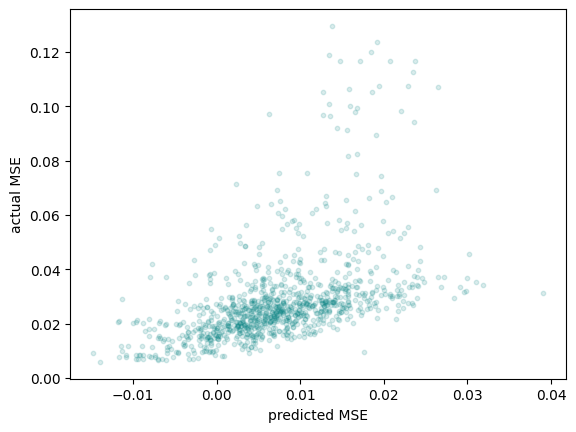

In [148]:
plt.scatter(mse_guess[:1000], mse[:1000], alpha=0.15, s=10, color="teal")
plt.xlabel("predicted MSE")
plt.ylabel("actual MSE")

Text(0, 0.5, 'actual MSE')

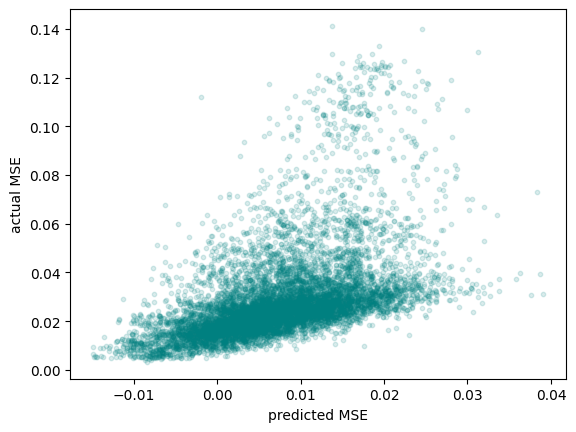

In [189]:
plt.scatter(mse_guess, mse, alpha=0.15, s=10, color="teal")
plt.xlabel("predicted MSE")
plt.ylabel("actual MSE")

In [164]:
from ms2deepscore.train_new_model.data_generators import DataGeneratorEmbeddingEvaluation
from ms2deepscore.SettingsMS2Deepscore import SettingsEmbeddingEvaluator
from tqdm.notebook import tqdm

data_gen_val = DataGeneratorEmbeddingEvaluation(pos_val_spectra, ms2ds_model, SettingsEmbeddingEvaluator())

ms2ds_embedding_evaluator.eval()
tanimoto_scores, ms2ds_scores, embeddings = data_gen_val[0]
real_mse_matrix = ((tanimoto_scores - ms2ds_scores) ** 2).cpu().detach().numpy()
predicted_mses = ms2ds_embedding_evaluator(embeddings.reshape(-1, 1, 500).to("cpu")).cpu().detach().numpy().ravel()

Selected 1009 spectra with unique inchikeys for calculating tanimoto scores (out of 9705 spectra)


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:00<00:00, 28039.28it/s]


Text(0, 0.5, 'predicted mse')

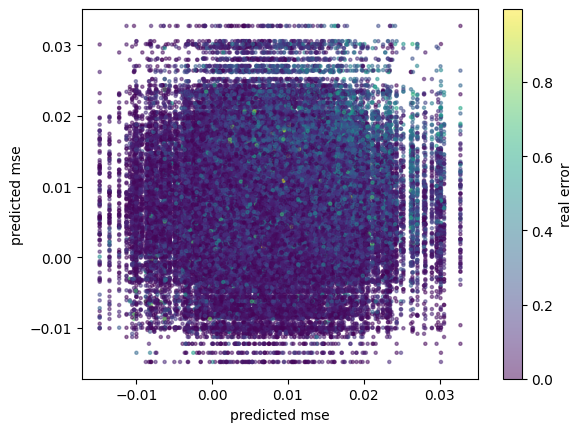

In [184]:
indexes = np.arange(predicted_mses.shape[0])
assert predicted_mses.shape[0] == real_mse_matrix.shape[0] ==real_mse_matrix.shape[1]
rng = np.random.default_rng(seed=0)
sample_idx_1 = rng.choice(indexes, 100000)
sample_idx_2 = rng.choice(indexes, 100000)

plt.scatter(predicted_mses[sample_idx_1], predicted_mses[sample_idx_2],
            c=real_mse_matrix[sample_idx_1,sample_idx_2]**0.5, s=5, alpha=0.5, cmap="viridis"
           )
cb = plt.colorbar()
cb.set_label("real error")
plt.xlabel("predicted mse")
plt.ylabel("predicted mse")

## Train linear model

In [190]:
# load training spectra
training_spectra = list(load_from_mgf(os.path.join(data_folder, "training_and_validation_split", "positive_training_spectra.mgf"))) + \
    list(load_from_mgf(os.path.join(data_folder, "training_and_validation_split", "negative_training_spectra.mgf")))

In [217]:
import numpy as np
from ms2deepscore.models.SiameseSpectralModel import compute_embedding_array
from ms2deepscore.vector_operations import cosine_similarity_matrix
from ms2deepscore.benchmarking.calculate_scores_for_validation import get_tanimoto_score_between_spectra

def select_one_spectrum_per_inchikey(spectra):
    inchikeys14_array = np.array([s.get("inchikey")[:14] for s in spectra])
    unique_inchikeys = np.unique(inchikeys14_array)
    rng = np.random.default_rng(seed=0)
    selected_spectra = []
    for inchikey in unique_inchikeys:
        matching_spectra_idx = np.where(inchikeys14_array == inchikey)[0]
        specrum_id = rng.choice(matching_spectra_idx)
        selected_spectra.append(spectra[specrum_id])
    return selected_spectra

def calculate_MAE_training(spectrums, ms2deepscore_model, embedding_evaluator, nr_of_samples=3000):
    selected_spectra = select_one_spectrum_per_inchikey(spectrums)
    if nr_of_samples > len(selected_spectra):
        nr_of_samples = len(selected_spectra)
    rng = np.random.default_rng(seed=0)
    indices = rng.choice(np.arange(0, len(selected_spectra)), nr_of_samples, replace=False)
    selected_spectra = [selected_spectra[i] for i in indices]
    
    embeddings = compute_embedding_array(ms2deepscore_model, selected_spectra)
    ms2ds_scores = cosine_similarity_matrix(embeddings, embeddings)
    tanimoto_scores = get_tanimoto_score_between_spectra(selected_spectra, selected_spectra,
                                                         fingerprint_type="daylight",
                                                         nbits=2048,
                                                        )
    MAEs = abs(tanimoto_scores - ms2ds_scores)

    predicted_mse = embedding_evaluator.compute_embedding_evaluations(embeddings)
    return MAEs, predicted_mse.ravel()


In [218]:
training_MAEs, predicted_mse_training = calculate_MAE_training(training_spectra, ms2ds_model, ms2ds_embedding_evaluator)

3000it [00:17, 169.92it/s]
Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:08<00:00, 339.16it/s]


Calculating tanimoto scores


In [219]:
training_MAEs.shape

(3000, 3000)

In [221]:
from ms2deepscore.models.LinearEmbeddingEvaluation import LinearModel

def train_linear_model(predicted_mse, MAEs):
    indexes = np.arange(predicted_mse.shape[0])
    assert predicted_mse.shape[0] == MAEs.shape[0] == MAEs.shape[1]
    sample_idx_1 = np.random.choice(indexes, 100000)
    sample_idx_2 = np.random.choice(indexes, 100000)
    X = np.vstack([predicted_mse[sample_idx_1], predicted_mse[sample_idx_2]])
    X = X.T
    y = MAEs[sample_idx_1, sample_idx_2]
    linear_model = LinearModel()
    linear_model.fit(X, y)
    return linear_model
linear_model = train_linear_model(predicted_mse_training, training_MAEs)

In [222]:
linear_model.model.coef_

array([  0.       ,   1.487129 ,   1.4725646,   4.524166 , 192.93036  ,
         6.1371207], dtype=float32)

## Validation of linear model

In [251]:
selected_all_val_spectra = select_one_spectrum_per_inchikey(all_val_spectra)
predicted_mse, ms2ds_scores, tanimoto_scores, val_MSEs, val_MAEs = calculate_MSE(selected_all_val_spectra, ms2ds_model, ms2ds_embedding_evaluator)


1404it [00:08, 174.87it/s]
Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1404/1404 [00:04<00:00, 344.80it/s]


Calculating tanimoto scores


In [209]:
val_MSEs.shape

(1009, 1009)

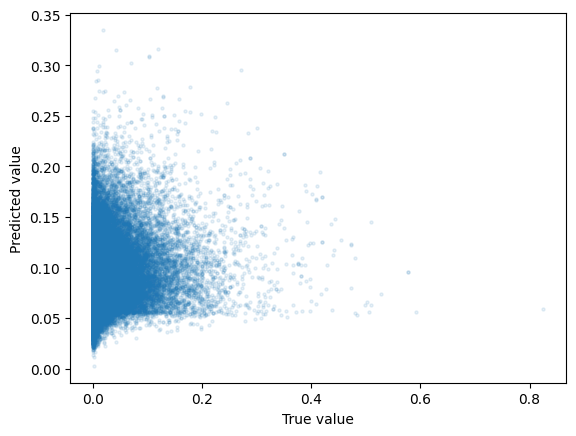

In [252]:
from matplotlib import pyplot as plt

def scatter_plot(predicted_mse, MSEs):
    indexes = np.arange(predicted_mse.shape[0])
    assert predicted_mse.shape[0] == MSEs.shape[0] == MSEs.shape[1]
    sample_idx_1 = np.random.choice(indexes, 100000)
    sample_idx_2 = np.random.choice(indexes, 100000)
    X = np.vstack([predicted_mse[sample_idx_1], predicted_mse[sample_idx_2]])
    X = X.T
    y = MSEs[sample_idx_1, sample_idx_2]
    y_true = y
    y_pred = linear_model.predict(X)
    
    plt.scatter(y_true, y_pred, alpha=0.1, s=5)
    plt.xlabel("True value")
    plt.ylabel("Predicted value")
scatter_plot(predicted_mse, val_MSEs)

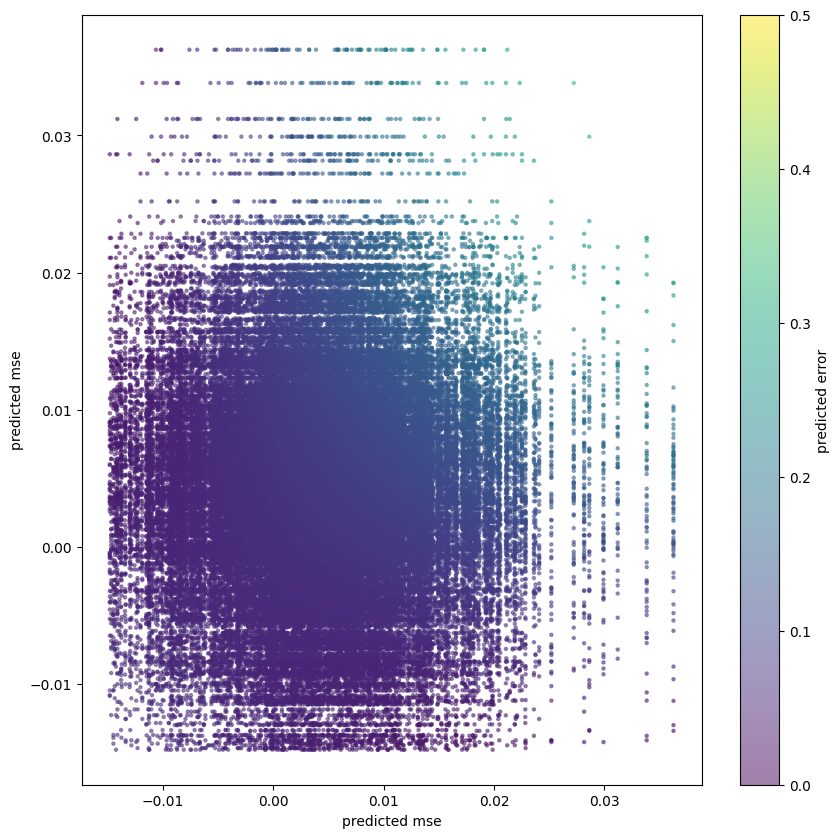

In [254]:
indexes = np.arange(predicted_mse.shape[0])
rng = np.random.default_rng(seed=0)
sample_idx_1 = rng.choice(indexes, 100000)
sample_idx_2 = rng.choice(indexes, 100000)
X = np.vstack([predicted_mse[sample_idx_1], predicted_mse[sample_idx_2]])
X = X.T
y_pred = linear_model.predict(X)
plt.figure(figsize=(10, 10))
plt.scatter(predicted_mse[sample_idx_1], predicted_mse[sample_idx_2],
            c=y_pred, s=5, alpha=0.5, cmap="viridis"
           )
cb = plt.colorbar()
cb.set_label("predicted error")
plt.xlabel("predicted mse")
plt.ylabel("predicted mse")
plt.clim(0, 0.5)

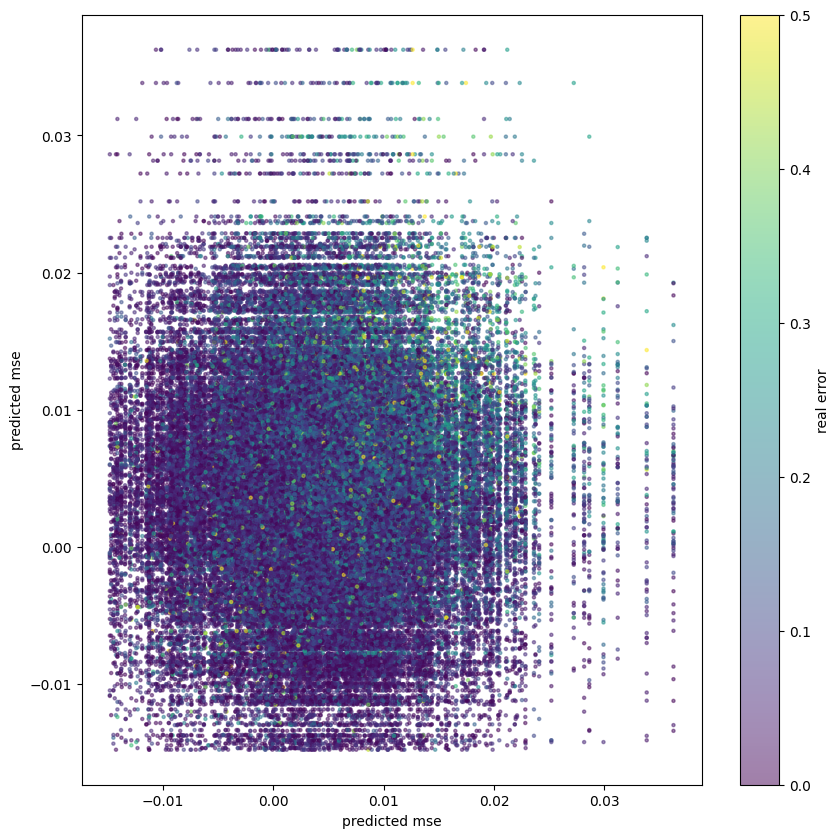

In [253]:
indexes = np.arange(predicted_mse.shape[0])
assert predicted_mse.shape[0] == val_MAEs.shape[0] == val_MAEs.shape[1]
rng = np.random.default_rng(seed=0)
sample_idx_1 = rng.choice(indexes, 100000)
sample_idx_2 = rng.choice(indexes, 100000)
plt.figure(figsize=(10, 10))

plt.scatter(predicted_mse[sample_idx_1], predicted_mse[sample_idx_2],
            c=val_MAEs[sample_idx_1,sample_idx_2], s=5, alpha=0.5, cmap="viridis"
           )
cb = plt.colorbar()
cb.set_label("real error")
plt.xlabel("predicted mse")
plt.ylabel("predicted mse")
plt.clim(0, 0.5)

# FInd example spectra

0.03131646


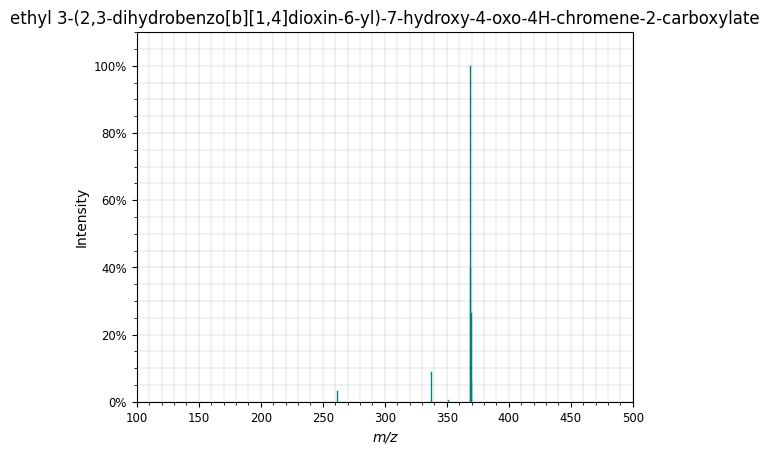

0.031678602


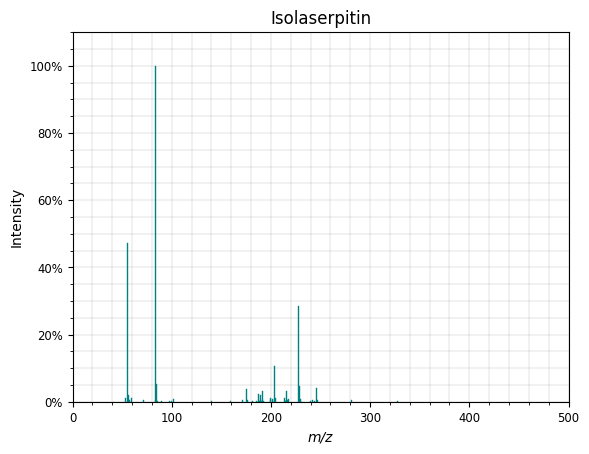

0.031782985


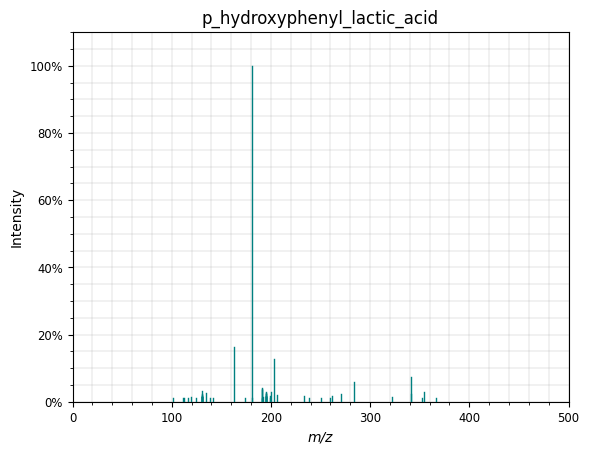

0.03190784


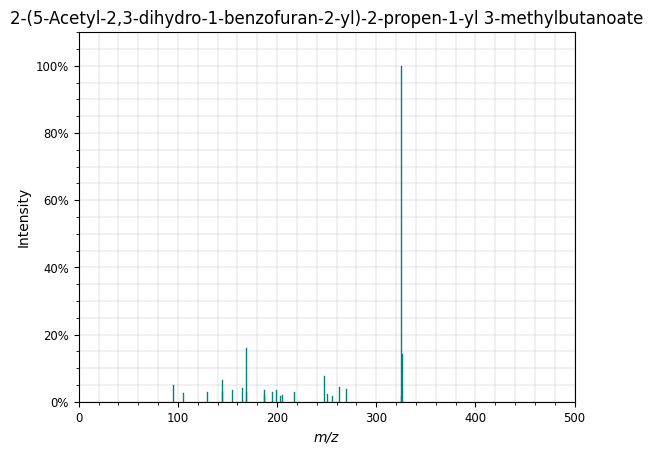

0.03191808


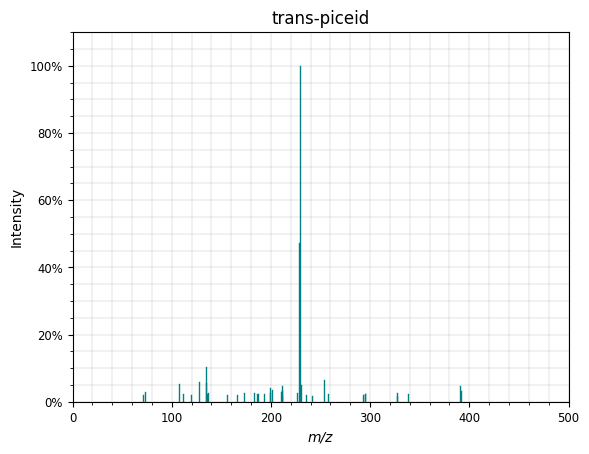

0.031966753


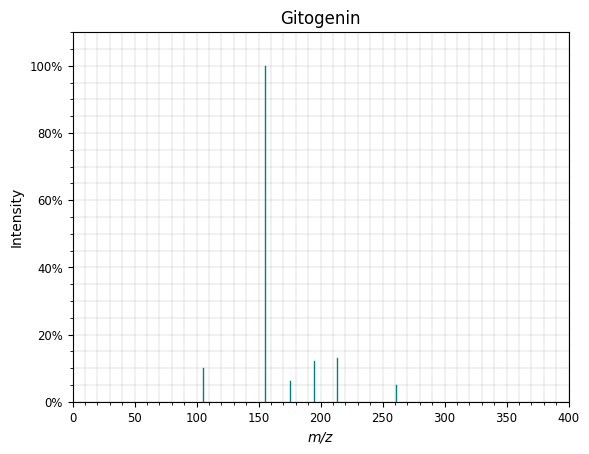

0.031983107


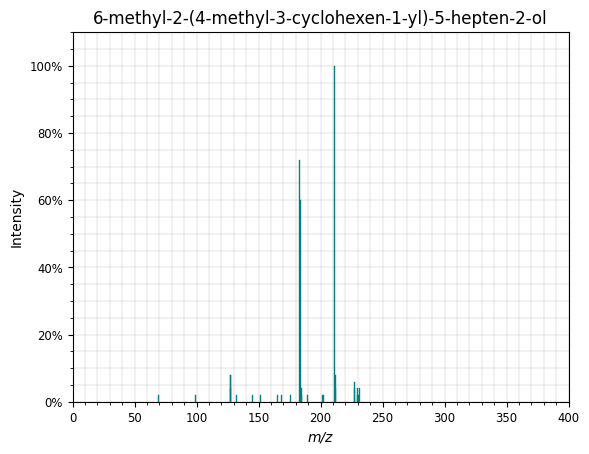

0.03270383


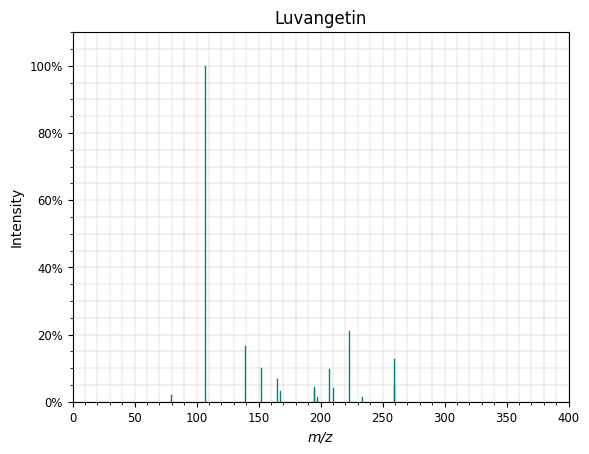

0.032749057


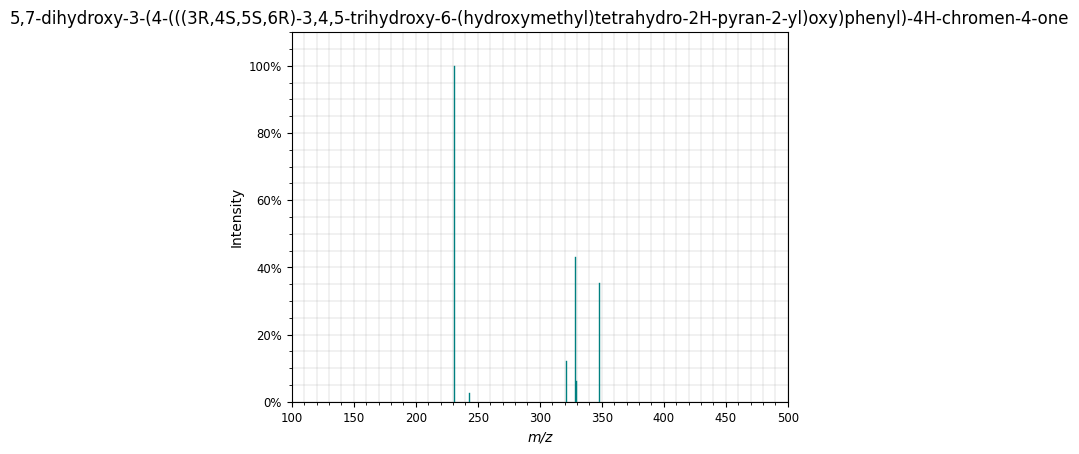

0.033562914


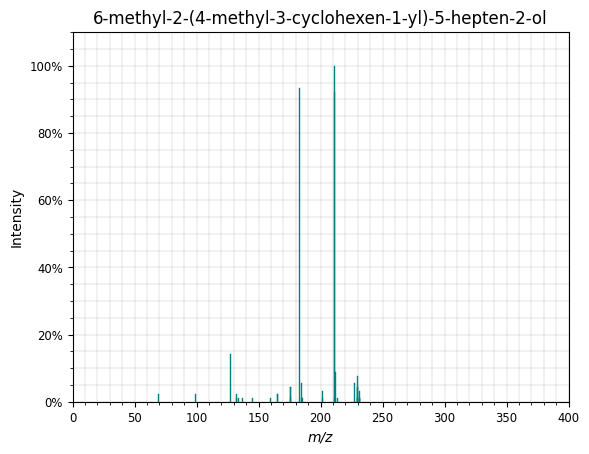

0.0338116


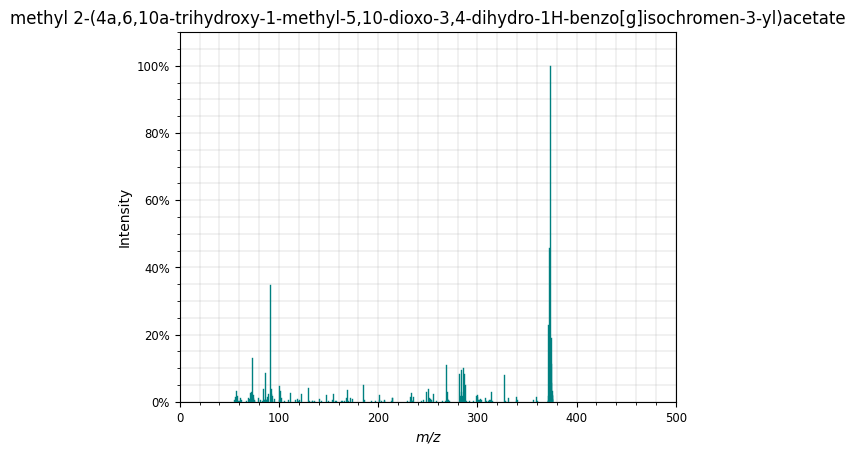

0.03382632


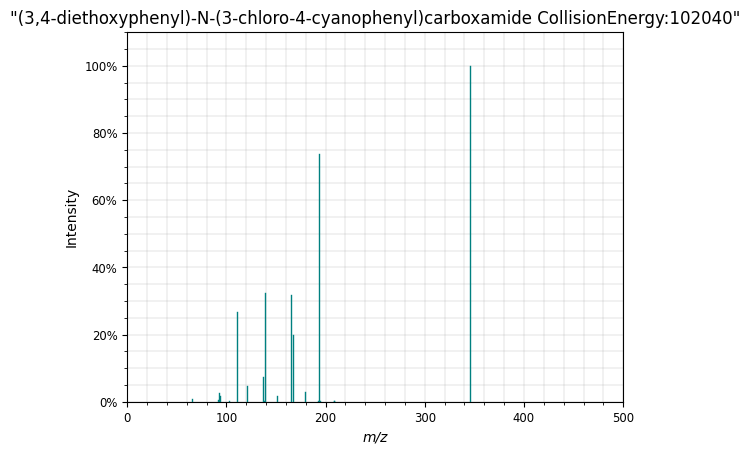

0.035472274


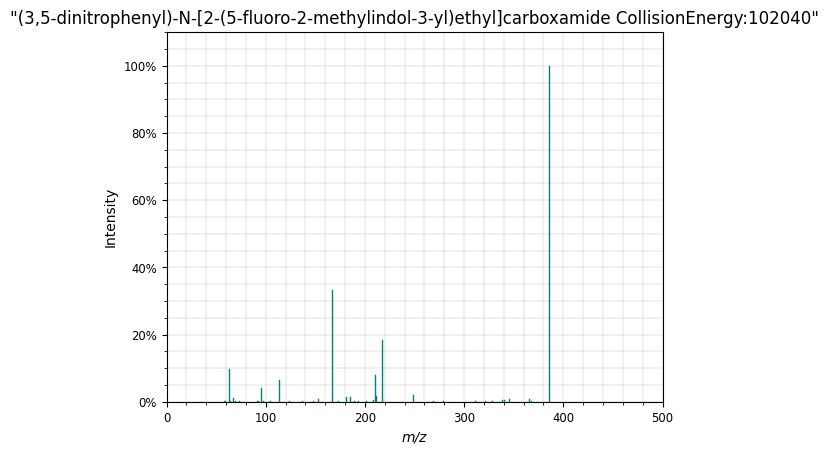

0.03581904


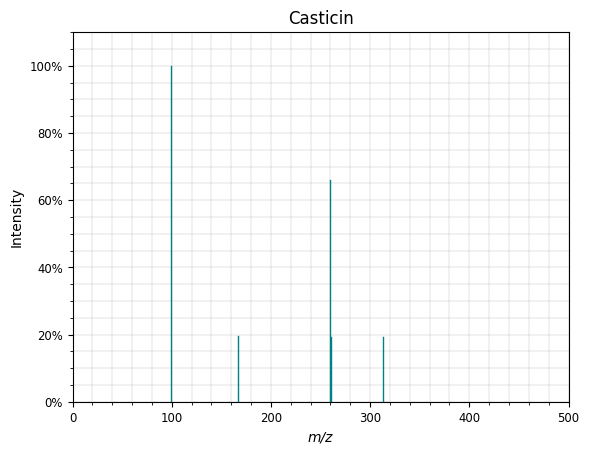

0.0362491


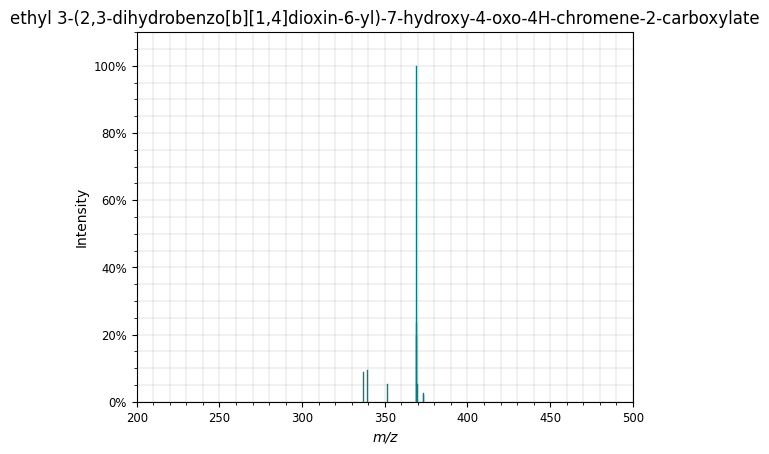

0.036253974


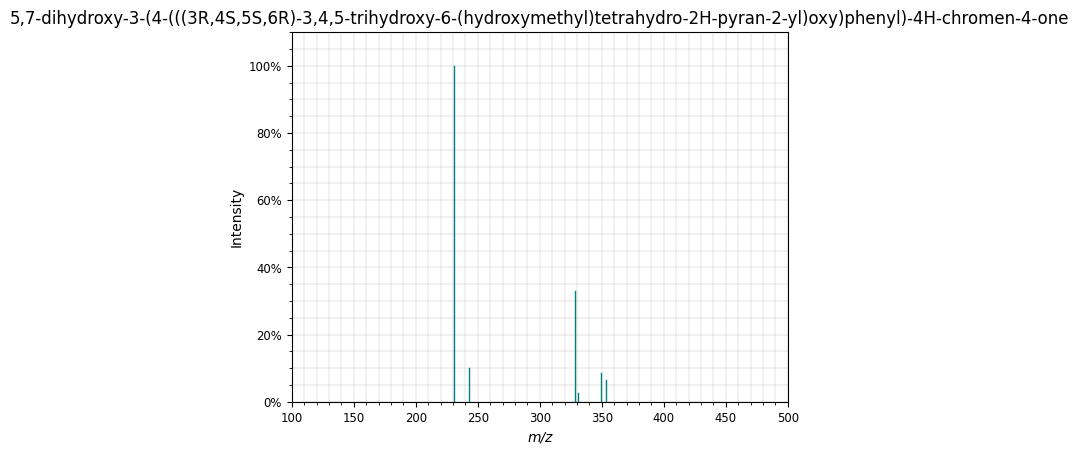

0.03756556


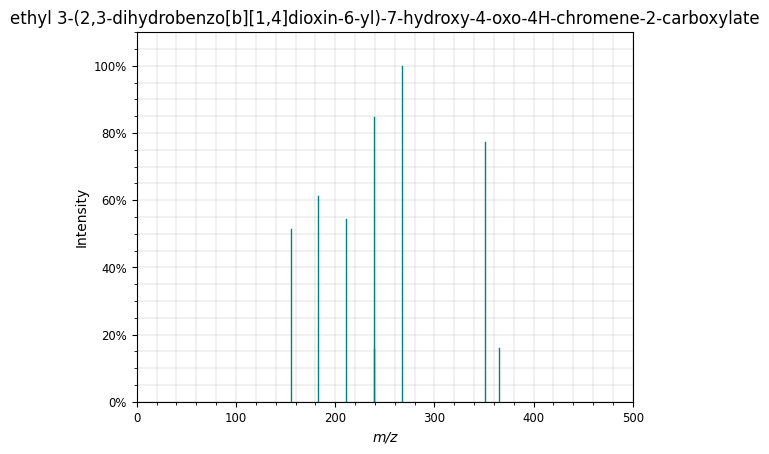

0.038349375


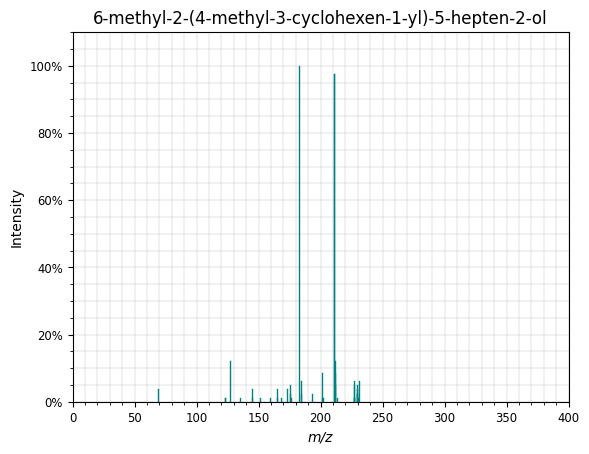

0.038656086


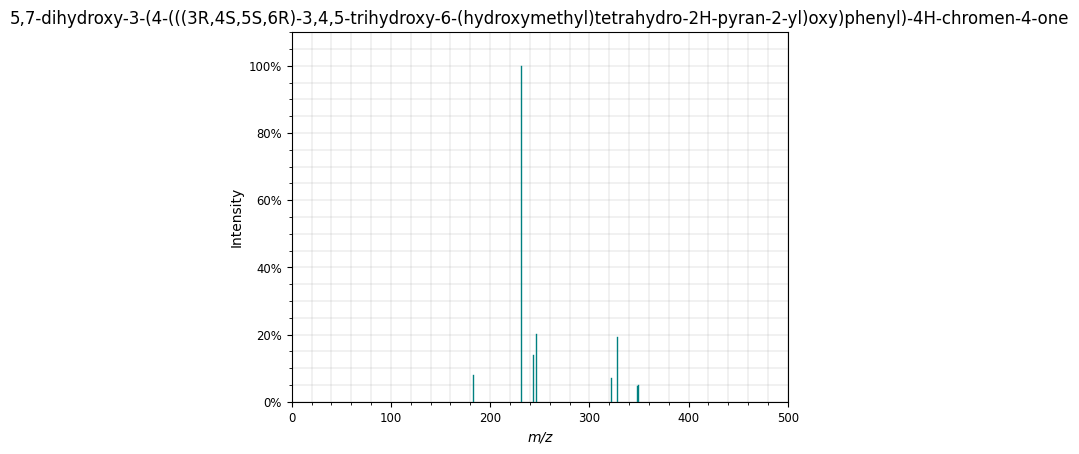

0.03910236


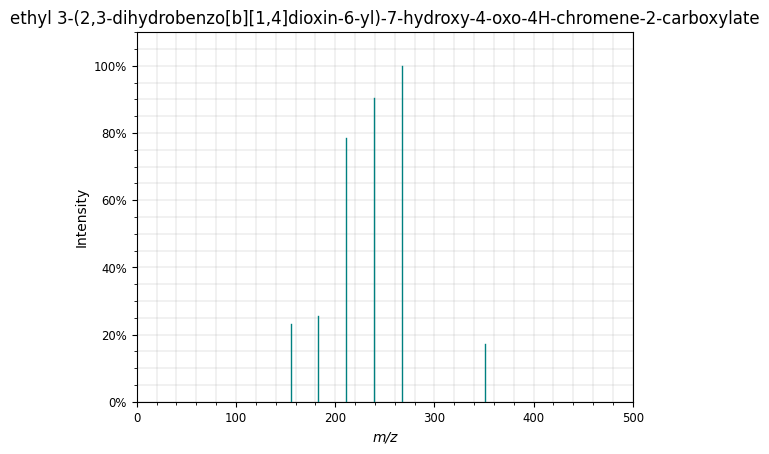

In [68]:
from matchms.plotting.spectrum_plots import plot_spectrum
import matplotlib.pyplot as plt

for index in sorted_indexes[-20:]:
    spectrum = all_spectra[index]
    print(predicted_mse[index])
    plot_spectrum(spectrum)
    plt.show()

# Find correlation between metadata and predicted mse

Text(0, 0.5, 'predicted mse')

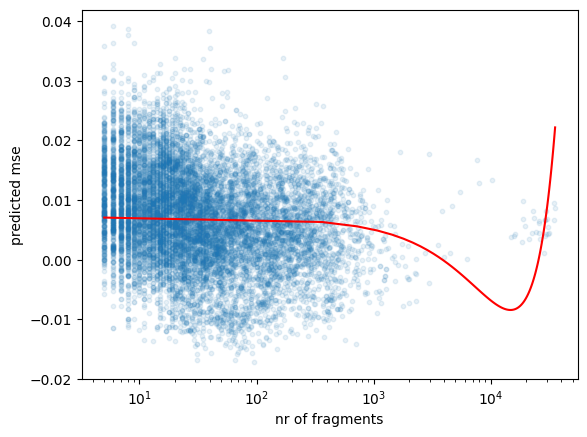

In [69]:
from matchms.plotting.spectrum_plots import plot_spectrum
import matplotlib.pyplot as plt
nr_of_peaks = []
sorted_predicted_mse = []
for index in sorted_indexes:
    spectrum = all_spectra[index]
    nr_of_peaks.append(len(spectrum.mz))
    sorted_predicted_mse.append(predicted_mse[index])
# Perform linear regression to fit a line
coefficients = np.polyfit(nr_of_peaks, sorted_predicted_mse, 1)
poly_eq = np.poly1d(coefficients)
line_x = np.linspace(min(nr_of_peaks), max(nr_of_peaks), 100)
line_y = poly_eq(line_x)
plt.plot(line_x, line_y, color='red', label='Line of Best Fit')

plt.scatter(nr_of_peaks, sorted_predicted_mse, alpha=0.1, s=10)
plt.xscale("log")
plt.xlabel("nr of fragments")
plt.ylabel("predicted mse")


Text(0, 0.5, 'predicted mse')

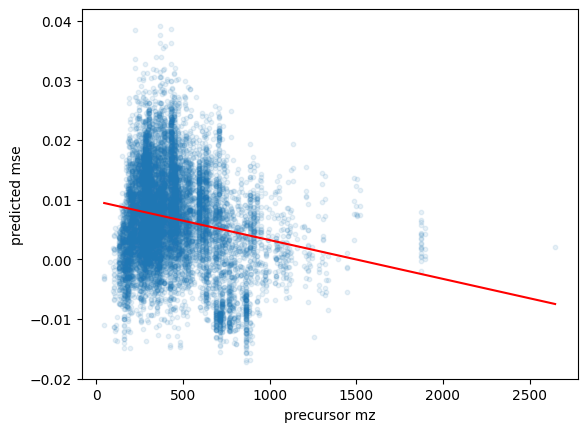

In [55]:
from matchms.plotting.spectrum_plots import plot_spectrum
import matplotlib.pyplot as plt
mass_of_compound = []
sorted_predicted_mse = []
for index in sorted_indexes:
    spectrum = all_spectra[index]
    mass_of_compound.append(spectrum.get("precursor_mz"))
    sorted_predicted_mse.append(predicted_mse[index])

# Perform linear regression to fit a line
coefficients = np.polyfit(mass_of_compound, sorted_predicted_mse, 1)
poly_eq = np.poly1d(coefficients)
line_x = np.linspace(min(mass_of_compound), max(mass_of_compound), 100)
line_y = poly_eq(line_x)
plt.plot(line_x, line_y, color='red', label='Line of Best Fit')

plt.scatter(mass_of_compound, sorted_predicted_mse, alpha=0.1, s=10)
plt.xlabel("precursor mz")
plt.ylabel("predicted mse")


Text(0, 0.5, 'predicted mse')

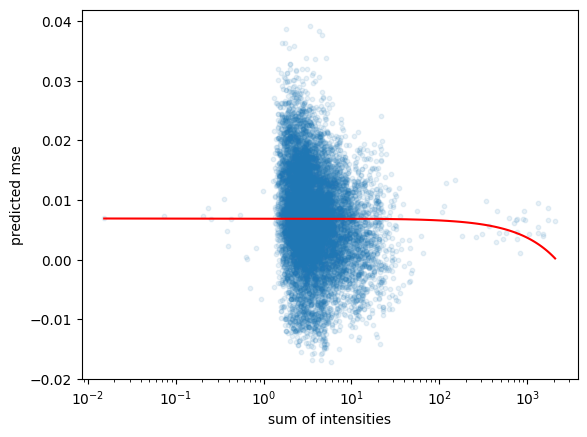

In [64]:
from matchms.plotting.spectrum_plots import plot_spectrum
import matplotlib.pyplot as plt
import numpy as np
mass_of_compound = []
sorted_predicted_mse = []
for index in sorted_indexes:
    spectrum = all_spectra[index]
    mass_of_compound.append(sum(spectrum.intensities))
    sorted_predicted_mse.append(predicted_mse[index])

# Perform linear regression to fit a line
coefficients = np.polyfit(mass_of_compound, sorted_predicted_mse, 1)
poly_eq = np.poly1d(coefficients)
line_x = np.linspace(min(mass_of_compound), max(mass_of_compound), 100)
line_y = poly_eq(line_x)
plt.plot(line_x, line_y, color='red', label='Line of Best Fit')

plt.scatter(mass_of_compound, sorted_predicted_mse, alpha=0.1, s=10)
# plt.xlim((0,50))
plt.xscale("log")
plt.xlabel("sum of intensities")
plt.ylabel("predicted mse")

Text(0, 0.5, 'predicted mse')

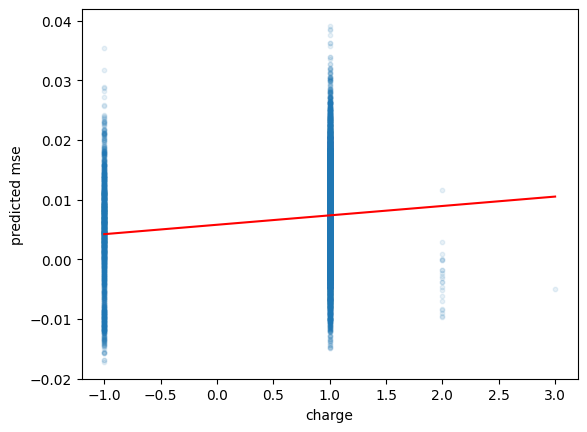

In [71]:
from matchms.plotting.spectrum_plots import plot_spectrum
import matplotlib.pyplot as plt
import numpy as np
mass_of_compound = []
sorted_predicted_mse = []
for index in sorted_indexes:
    spectrum = all_spectra[index]
    mass_of_compound.append(spectrum.get("charge"))
    sorted_predicted_mse.append(predicted_mse[index])

# Perform linear regression to fit a line
coefficients = np.polyfit(mass_of_compound, sorted_predicted_mse, 1)
poly_eq = np.poly1d(coefficients)
line_x = np.linspace(min(mass_of_compound), max(mass_of_compound), 100)
line_y = poly_eq(line_x)
plt.plot(line_x, line_y, color='red', label='Line of Best Fit')

plt.scatter(mass_of_compound, sorted_predicted_mse, alpha=0.1, s=10)
# plt.xlim((0,50))
plt.xlabel("charge")
plt.ylabel("predicted mse")